In [1]:
using PyPlot, FileIO, AnomalyDetection, EvalCurves, Distances
import PyPlot: plot
include("./plots.jl")

┌ Info: Precompiling AnomalyDetection [2069a70b-aa58-5cc0-a11c-32e347b774c5]
└ @ Base loading.jl:1187
┌ Info: Precompiling FluxExtensions [76425322-8995-11e8-0106-93ec95767fb2]
└ @ Base loading.jl:1187


loaded


PyPlot.plot

In [2]:
dataset = load("toy_data_3.jld2")["data"]

Dataset(Float32[0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [3]:
X = AnomalyDetection.Float.(dataset.data);
Y = dataset.labels;
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [4]:
# model parameters
k = 11 # number of nearest neighbors
metric = Distances.Euclidean() # any of metric from Distance package
distances = "all" # "all"/"last" - use average of all or just the k-th nearest neighbour
contamination = size(Y[Y.==1],1)/size(Y,1)
reduced_dim = false # if dim > 10, use PCA to reduce it
Beta = 1.0
#model = kNN(k, metric = metric, weights = weights, reduced_dim = reduced_dim)
model = kNN(k, contamination, metric = metric, distances = distances,
    reduced_dim = reduced_dim, Beta = Beta)

kNN(11, Array{Float32}(0,0), Euclidean(0.0), "all", 0.1262135922330097, 0.0, false, (Array{Float32}(0,0), Float32[]), false, 1.0f0)

In [5]:
size(nX)

(2, 90)

In [6]:
AnomalyDetection.fit!(model, nX);
AnomalyDetection.setthreshold!(model, X);

In [7]:
AnomalyDetection.anomalyscore(model, X)

103-element Array{Float32,1}:
 0.007143839 
 0.009171105 
 0.0072819605
 0.017360525 
 0.03417075  
 0.011671852 
 0.019762028 
 0.0089581525
 0.0072664674
 0.008841877 
 0.0072113504
 0.03011969  
 0.044922557 
 ⋮           
 0.27724397  
 2.0071218   
 1.8013765   
 0.17822318  
 1.4604675   
 0.49424717  
 1.0205247   
 0.16694188  
 0.74079776  
 0.59925574  
 0.30135328  
 0.24636139  

In [8]:
# this fits the model and produces predicted labels
tryhat, tstyhat = AnomalyDetection.rocstats(X, Y, X, Y, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 90
  fp = 0
  fn = 0
precision: 1.0
f1score: 1.0
recall: 1.0
false positive rate: 0.0
equal error rate: 0.0

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 90
  fp = 0
  fn = 0
precision: 1.0
f1score: 1.0
recall: 1.0
false positive rate: 0.0
equal error rate: 0.0


In [9]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = range(xl[1], stop=xl[2], length=30)
y = range(yl[1], stop=yl[2], length=30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

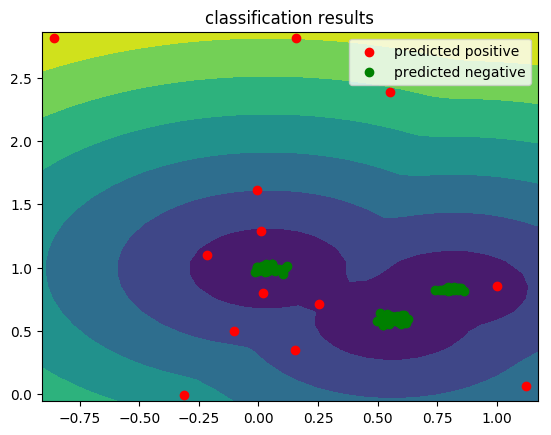

In [10]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

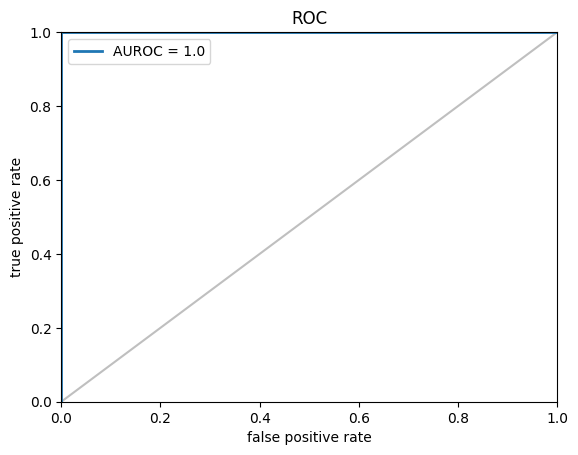

In [12]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),digits=3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()